In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from typing import Dict, List
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [3]:
#this simulate a circuit (without measurement) and output results in the format of histogram.
def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    # for i in range(2,20):
    #     assert counter[i]==0
        
    return counter
def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)

In [4]:
def binary(decimal):
    return bin(decimal)[2:]

def roundint(number):
    return int(np.rint(number))

def unnest_matrix(matrix):
    return [col for row in matrix for col in row]

def norm(matrix):
    return sum([np.abs(item)**2 for item in unnest_matrix(matrix)])

# def group_matrix(matrix, submatrix_size):
#     rows = len(matrix)
#     cols = len(matrix[0])
#     submatrixes = []
#     for i in range(0, rows, submatrix_size):
#         for j in range(0, cols, submatrix_size):
#             submatrix = [row[j:j+submatrix_size] for row in matrix[i:i+submatrix_size]]
#             submatrixes.append(submatrix)
#     return np.array(submatrixes)

In [5]:
def qasm_simulate(qc,nshots=None):
    
    if nshots == None:
        shots = 2**len(qc.qubits)
    else:
        shots = nshots
        
        
    options = {}
    
    # Use Aer's qasm_simulator
    from qiskit import Aer
    backend_sim = Aer.get_backend('qasm_simulator')

    from qiskit import transpile
    qcm = qc.copy()
    qcm.measure_all()
    job_sim = backend_sim.run(
        transpile(qcm, backend = backend_sim),
                  # basis_gates = ['u1', 'u2', 'u3', 'cx'],
                  # optimization_level = 3),
        shots=shots)
    
    result_sim = job_sim.result()
    counts_ideal = result_sim.get_counts(qcm)
    
    return qcm,job_sim,result_sim,counts_ideal

def hist_bin_to_dec(d,stand=True):
    new_d={}
    if stand==True:
        total = sum(list(d.values()))
    else:
        total=1
        
    for key,value in d.items():
        new_d[int(key,2)]=value/total
    return new_d

In [6]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')

# Enconder:

In [7]:
def encode(image):
    
    Norm = norm(image)
    unnested_image = unnest_matrix(image)
    
    l = len(image)
    L = l**2
    
    n=int(np.ceil(np.log2(L)))
    N=2**n
    
    initial_state = [0]*N
    
    for index in range(N-L,N):
        initial_state[index] = unnested_image[index-(N-L)]/np.sqrt(Norm)
    
    qr = qiskit.QuantumRegister(n)
    qc = qiskit.QuantumCircuit(qr)

    qc.initialize(initial_state,qr)
    return qc

# Simulations:

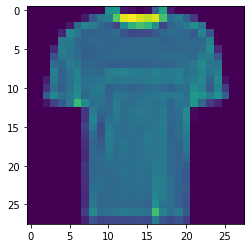

In [8]:
A = images[101]
plt.imshow(A)

In [9]:
qc = encode(A)
count_gates(qc)

Counter({10: 1})

In [10]:
H = simulate(qc)
Out = qasm_simulate(qc)
D = hist_bin_to_dec(Out[3])

Note that these simulations deliver very similar results, up to a 10e-2 coincidence.

In [11]:
qcv2 = qc.decompose(reps=20)
count_gates(qcv2)

Counter({1: 1033, 2: 1022})

In [12]:
Hv2 = simulate(qcv2)
Outv2 = qasm_simulate(qcv2)
Dv2 = hist_bin_to_dec(Out[3])

In [13]:
IList = [list(H.items()),list(Hv2.items()),list(D.items()),list(Dv2.items())]
for sublist in IList:
    sublist.sort(key=lambda a: a[0])

In [14]:
#Consistency checks, there are 100 elements out of the qasm simulations 

sum([item not in Hv2.keys() for item in H.keys()])
sum([item not in Dv2.keys() for item in D.keys()])

sum([item not in D.keys() for item in H.keys()])
sum([item not in Dv2.keys() for item in Hv2.keys()])

len(Hv2.keys())
len(Dv2.keys())

sum([np.abs(IList[0][item][1]-IList[1][item][1]) > 1e-3 for item in range(len(IList[0]))])
sum([np.abs(IList[2][item][1]-IList[3][item][1]) > 1e-3 for item in range(len(IList[2]))])

0

0

98

98

487

389

0

0

In [19]:
# # import packages
# from qiskit import QuantumCircuit
# from qiskit.visualization import plot_histogram
# from qiskit_ionq import IonQProvider

# provider = IonQProvider()

# # view list of available backends
# provider.backends()

# # load backend by using the get_backend method
# backend_ionq = provider.get_backend("ionq_simulator")

In [18]:
# # submit the circuit
# job_ionq = backend_ionq.run(qc)
# result_ionq = job_ionq.result()
# counts_ionq = result_ionq.get_counts()
# print(counts_ionq)

# # as mentioned before, these "counts" are really just a uniform sampling 
# # of the underlying probabilities returned by the simulator. To get the 
# # true probabilities, you can use the get_probabilities() method:

# probabilities_ionq = result_ionq.get_probabilities()
# print(probabilities_ionq)

# #visualize counts
# plot_histogram(counts_ionq)

# Decoder:

In [17]:
InteractiveShell.ast_node_interactivity = "last_expr"
def decode(hist):
    
    l=28
    L=l**2
    
    n=10
    N=2**n
    
    image = [0]*L
    for key,value in H.items():
        image[key-(N-L)] = value
    
    matrix = [image[i:i+l] for i in range(0, L, l)]
    return matrix    

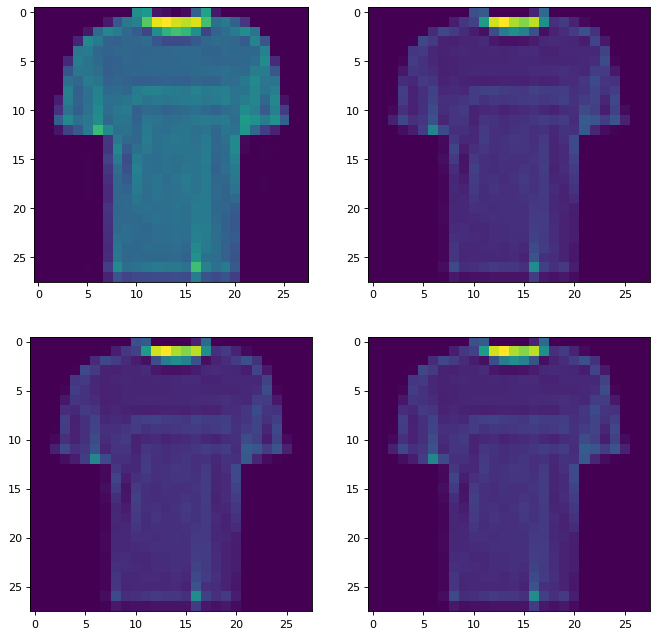

In [35]:
fig = plt.figure(figsize=(10,10),dpi=80)
fig.add_subplot(2,2,1)
plt.imshow(A)
for i in range(3):
    fig.add_subplot(2,2,i+2)
    plt.imshow(decode(IList[i]), aspect='auto')
plt.show()

# Estimate accuracy

In [39]:
[image_mse(A,decode(IList[i]))*100 for i in range(3)]
#The same for all

[0.00011070569435982095, 0.00011070569435982095, 0.00011070569435982095]

# Run All:

In [42]:
def run_part1(image):
    #encode image into a circuit
    circuit=encode(image)

    #simulate circuit
    histogram=simulate(circuit)

    #reconstruct the image
    image_re=decode(histogram)

    return circuit,image_re,plt.imshow(image_re)

(<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f07b6f74130>,
 [[0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0.0036657363786930285,
   0.00427068909424954,
   5.195204618329241e-05,
   1.8702736625985254e-05,
   0,
   1.1314001168805575e-05,
   0.0014410343121329734,
   0.005126166121401049,
   6.672951709764976e-05,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  [0,
   0,
   0,
   0,
   0,
   0,
   0,
   7.48109465039384e-05,
   0.0011314001168805674,
   0.00235539032495889,
   0.002896384299214216,
   0.008247906852059264,
   0.013973022341457947,
   0.015014141346971115,
   0.013189123689047857,
   0.012214503302649296,
   0.013522309478570036,
   0.007481094650393909,
   0.0019970366552857165,
   0.002545650262981257,
   0.0014410343121329786,
   0.0003694367728589571,
   0,
   0,
   0,
   0,
   0,
   0],
  [0,
   0,
   0,
   0,
   0,
   5.910988365743347e-05,
   0.0017880739806373429,
   0.0032150235158050775,
   0.002693194074141799,
   0.0017880739

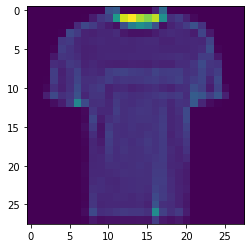

In [43]:
run_part1(A)